# The class used to handle the hsi (Hyperspectral image)

In [21]:
from spectral import *
import plotly.express as px
from scipy.io import loadmat
import numpy as np
import cv2
import time


class open_hsi:
    
    '''We first have to import the spectral module and then we can use 
    the open_image function to open the image in case it's a .lan format.
    In the case of .mat format, we have to use the scipy.io.loadmat function
    In the case of .tif or .tiff format, we have to use the cv2.imread function'''
    def __init__(self, hsipath):
        self.hsipath = hsipath
    def get_extention(self):
        '''This function returns the extention of the file'''
        return self.hsipath.split('.')[-1]
    def open_image(self):
        '''This function opens the image and returns the array of the image (width, height, band)'''
        if self.get_extention() == 'mat':
            ''' When opening the .mat file, 
            the image data is usualy stored on
            the last key of the dictionnary.''' 
            pref_mat = loadmat(self.hsipath)
            im_array = pref_mat[list(pref_mat.keys())[-1]] 
            return im_array
        if self.get_extention() == 'lan':
            
            im_spectral = open_image(self.hsipath)
            im_spectral = im_spectral.load()
            return im_spectral
        
        if (self.get_extention() == 'tif') or (self.get_extention() == 'tiff'):
            im_array = cv2.imread(self.hsipath)
            return im_array
        else :
            print('The file extention is not supported')
        
        
    def normalize(self):
        '''This function normalizes the array of 
        the image so that for each band we get a grayscale image
        note: this returns a float array, if an int array is needed
        the conversion must be done manually'''
        im_array = self.open_image()
        im_array = im_array.astype(float)
        im_array = (((im_array-im_array.min()) / (im_array.max()-im_array.min()))*255).astype('uint8')
        return im_array
    def view_image(self, band):
        
        '''This function plots the grayscale image of the hyperspectral cube's band'''
        im_array = self.normalize()
        fig = px.imshow(im_array[:,:,band],color_continuous_scale='gray')
        fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
        fig.show()
        
    def get_image(self, band):
        '''This function returns the grayscale image of the hyperspectral cube's band'''
        im_array = self.normalize()
        return im_array[:,:,band]
    
    def video(self, fps =5.0):
        '''This function returns a video of the hyperspectral cube'''
        im_array = self.normalize()
        height,width,layers=im_array.shape
        filename = f'output_video_{time.strftime("%Y%m%d-%H%M%S")}.mp4'
        video = cv2.VideoWriter(filename ,cv2.VideoWriter_fourcc(*'MP4V'), fps,
                                (width,height), isColor = False)
        images = []
        for i in range(0,layers-1):
            images.append(im_array[:,:,i])
            data = np.array(im_array[:,:,i], np.uint8)
            video.write(data)
        video.release()
        cv2.destroyAllWindows()
        print(f'The video has been saved successfully under the name: {filename}')
        
        #return images
        


In [22]:

open_hsi('PaviaU.mat').video(1)


The video has been saved successfully under the name: output_video_20221130-155048.mp4


# The Mask class is used to handle the hsi mask:

In [23]:
PaviaU_classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows', 'Other']

In [24]:
from spectral import *
import plotly.express as px
from scipy.io import loadmat
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
    
class open_hsi_mask(open_hsi):
    def __init__(self, hsipath, maskpath):
        ''' This function initializes the class with the path of the hyperspectral image and the path of the mask'''
        super().__init__(hsipath)
        self.maskpath = maskpath
    
        
    def get_extention(self):
        '''This function returns the extention of the file'''
        return self.maskpath.split('.')[-1]
    
    def open_ground_truth(self):
        '''This function reads the ground truth file and returns a numpy array'''
        if self.get_extention() == 'mat':
            pref_mat = loadmat(self.maskpath)
            im_array_gt = pref_mat[list(pref_mat.keys())[-1]]
            return im_array_gt
        if self.get_extention() == 'lan':
            im_spectral_gt = open_image(self.maskpath)
            im_spectral_gt = im_spectral_gt.load()
            return im_spectral_gt
        if (self.get_extention() == 'tif') or (self.get_extention() == 'tiff'):
            im_array_gt = cv2.imread(self.maskpath)
            return im_array_gt
        else: 
            print('The file extention is not supported')
            
    
    
    def get_class_pixels(self, class_number):
        '''This function returns the pixels of a specific class'''
        im_array_gt = self.open_ground_truth()
        if class_number > im_array_gt.max():
            print('The class number is higher than the maximum number of classes')
            return 0
        if class_number < im_array_gt.min():
            print('The class number is lower than the minimum number of classes')
            return 0

        class_pixels = im_array_gt == class_number
        return class_pixels
    
    def class_number(self):
        im_array_gt = self.open_ground_truth()
        '''This function returns the number of classes in the mask'''
        return int(im_array_gt.max()) - int(im_array_gt.min()) +1  
    

    def get_reflectance(self, class_number):
        '''This function returns the reflectance of a specific class'''
        class_pixels = self.get_class_pixels(class_number)
        im_array = open_hsi(self.hsipath).normalize()
        layers = im_array.shape[2]
        band = []
        reflectance = []
        for i in range(0,layers-1):
            band.append(i)
            filtered_pixels = class_pixels * im_array[:,:,i]
            reflectance.append(filtered_pixels.sum()/class_pixels.sum())
        return reflectance, band
        
    def view_reflectance(self, label= False):
        '''This function plots the reflectance of all classes'''
        plt.figure(figsize=(15,10))
        for i in range(0, self.class_number()):
            reflectance, band = self.get_reflectance(i)
            plt.plot(band, np.log(reflectance), label = label[i-1])
        plt.legend(loc='upper right')


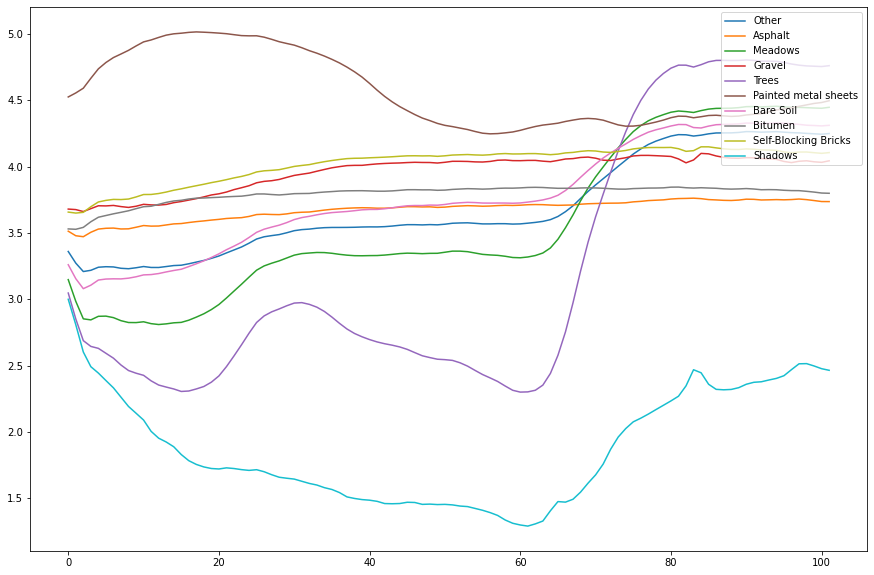

In [25]:
open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').view_reflectance(PaviaU_classes)

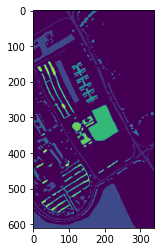

In [26]:
hsi_mask = open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').open_ground_truth()
plt.imshow(hsi_mask)

# Segmentation algorythm

#### Data preprocessing 

In [27]:
import pandas as pd
# First we need to open the hsi and the mask and store them in a dataframe
hsi_image = open_hsi('PaviaU.mat').open_image()
height, width, layers = hsi_image.shape # we will need these dimensions later
# reshape the image to a dataframe such as every column is a band and every row is a pixel
df = pd.DataFrame(hsi_image.reshape(-1,layers)) 
# get the mask in the collumn of the dataframe as a vector such as every value represents the class of the pixel
df['class'] = open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').open_ground_truth().reshape(-1)

The value count for each pixel in a class :
0    164624
2     18649
1      6631
6      5029
8      3682
4      3064
3      2099
5      1345
7      1330
9       947
Name: class, dtype: int64


" to see the number of pixels of each class, for a balanced dataset,\n we need to have the same number of pixels for each class,\n but it isn't the case with this dataset"

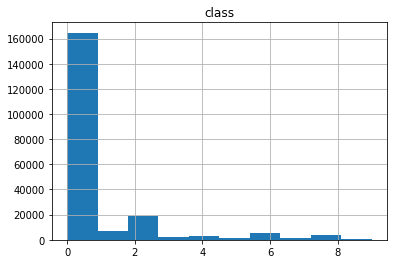

In [28]:
# We visualize the classes of the mask as a histogram
df.hist(column = ['class'])
print(f"The value count for each pixel in a class :\n"+f"{df['class'].value_counts()}" )

''' to see the number of pixels of each class, for a balanced dataset,
 we need to have the same number of pixels for each class,
 but it isn't the case with this dataset'''

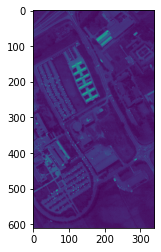

In [56]:
'''Each column in the dataframe represents the image's pixels in a band and the last column represents the class. in this case, the class is the ground truth. '''
plt.imshow(np.array(df[5]).reshape(height,width))# Check that we can reconstitute the image from the dataframe

In [57]:
from sklearn.model_selection import train_test_split
y = df['class']
X = df.drop('class', axis = 1)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

est = []
acc_score = []
for i in range(1,200,10):
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))
    est.append(i)
    print(f'Accuracy for {i} estimators : {accuracy_score(y_test, y_pred)}')
    
    
#clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)


Accuracy for 1 estimators : 0.7687720990035358
Accuracy for 11 estimators : 0.8427675988428158


KeyboardInterrupt: 

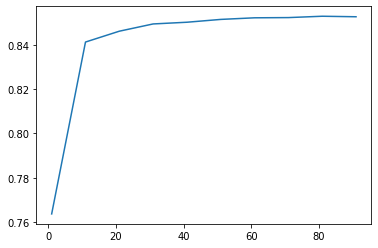

In [ ]:
%matplotlib inline
plt.plot(est, acc_score)

Note : 100 estimators are enough.

* To go further with the segmentation, we need to reduce the dimentionality of the dataframe. 

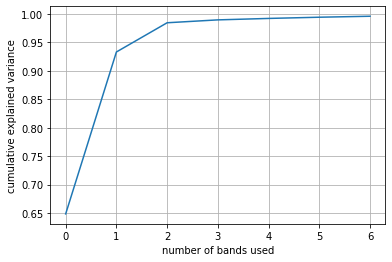

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(7).fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of bands used')
plt.ylabel('cumulative explained variance');
X_reduced = pca.transform(X_scaled)

It seems like 7 bands are enough to explain 99% of the variance in the data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)
est = []
acc_score = []
i = 1
    
while i<10:
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))
    est.append(i)
    print(f'Accuracy for {i} estimators : {accuracy_score(y_test, y_pred)}')
    i+=1

while i<=100 and i>=10:
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))
    est.append(i)
    print(f'Accuracy for {i} estimators : {accuracy_score(y_test, y_pred)}')
    i+=20
    

Accuracy for 1 estimators : 0.7486338797814208
Accuracy for 2 estimators : 0.7974766955962713
Accuracy for 3 estimators : 0.799228543876567
Accuracy for 4 estimators : 0.8082610093217615
Accuracy for 5 estimators : 0.8105271616843459
Accuracy for 6 estimators : 0.8139183542269367
Accuracy for 7 estimators : 0.8169720347155256
Accuracy for 8 estimators : 0.8190131790421087
Accuracy for 9 estimators : 0.8184828029572485
Accuracy for 10 estimators : 0.8195596271295403
Accuracy for 30 estimators : 0.8275313404050144
Accuracy for 50 estimators : 0.8304243008678881
Accuracy for 70 estimators : 0.8306814529090325
Accuracy for 90 estimators : 0.8307457409193185


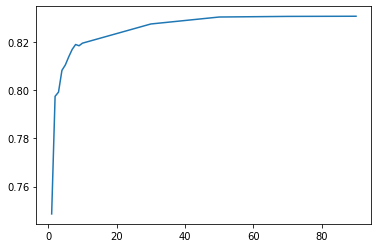

In [ ]:
plt.plot(est, acc_score)

In [ ]:
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

pca = SparsePCA(7).fit(X_scaled)# Takes too much time to run
X_reduced = pca.transform(X_scaled)
np.mean(pca.components_ == 0)

AttributeError: 'SparsePCA' object has no attribute 'explained_variance_ratio_'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.5, random_state=42)
est = []
acc_score = []
for i in range(1,100,10):
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))
    est.append(i)
    print(f'Accuracy for {i} estimators : {accuracy_score(y_test, y_pred)}')
    

Accuracy for 1 estimators : 0.7509836065573771
Accuracy for 11 estimators : 0.823076181292189
Accuracy for 21 estimators : 0.8285053037608486
Accuracy for 31 estimators : 0.8294985535197685
Accuracy for 41 estimators : 0.8304532304725168
Accuracy for 51 estimators : 0.830877531340405
Accuracy for 61 estimators : 0.8318900675024108
Accuracy for 71 estimators : 0.8325940212150434
Accuracy for 81 estimators : 0.8325650916104147
Accuracy for 91 estimators : 0.8327772420443588


Note : The sparce PCA function wields a slightly better result than the standard PCA, but the duration of the a takes a lot more time to compute

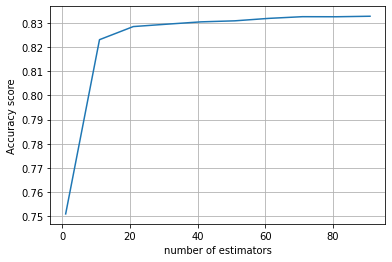

In [ ]:
plt.plot(est, acc_score)
plt.grid()
plt.xlabel('number of estimators')
plt.ylabel('Accuracy score');

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(f'Accuracy for 100 estimators : {acc_score} ')

Accuracy for 100 estimators : 0.8553037608486017 


In [ ]:
y_pred = clf.predict(X_train)
acc_score = accuracy_score(y_train, y_pred)
print(f'Accuracy for X_test : {acc_score} ')

Accuracy for X_test : 0.9999793359966938 


In [ ]:
y_pred = clf.predict(X)
acc_score = accuracy_score(y, y_pred)
print(f'Accuracy for the total : {acc_score} ')

Accuracy for the total : 0.7937512054001928 


The large accuracy_score for the training batch compared to the test is probably due to the fact that the model is overfitted.

### SVM
According to the literature the SVM classifier has been widely used since its low generalization error rate and simple operation. However, the high spectral dimensionality of HSI usually causes the model parameters difficult to estimate when labeled samples are limited for training, which results in the “Hughes phenomenon”




[Fusion of PCA and Segmented-PCA Domain Multiscale 2-D-SSA for Effective Spectral-Spatial Feature Extraction and Data Classification in Hyperspectral Imagery]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(f'Accuracy for the SVM classifier : {acc_score} ')


Accuracy for the SVM classifier : 0.8131147540983606 


In [ ]:
y_pred = clf.predict(X_train)
acc_score = accuracy_score(y_train, y_pred)

print(f'Train accuracy for the SVM classifier : {acc_score} ')

Train accuracy for the SVM classifier : 0.8119851219176195 


Note : this classifier takes way too much time to train and test (79mn44s for training and testing)

Augmenting the data with multiple filters 

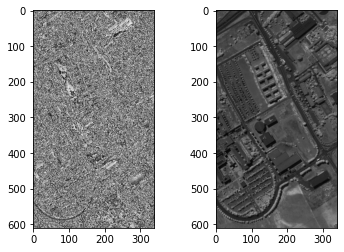

In [34]:
# Canny edge detection
import cv2
from random import seed
from random import randint
seed(1)
edges = cv2.Canny(hsi_image[:,:,randint(0, 102)].astype('uint8'),100,100)
plt.subplot(121),
plt.imshow(hsi_image[:,:,randint(0, 102)].astype('uint8'),cmap = 'gray')
plt.subplot(122)
plt.imshow(hsi_image[:,:,randint(0, 102)],cmap = 'gray')


the data is completelywrong andshould be redone "i'm sad :("

In [35]:
from sklearn.preprocessing import StandardScaler
test = StandardScaler().fit_transform(hsi_image[:,:,randint(0, 102)])


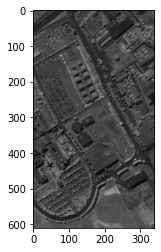

In [36]:
plt.imshow((test-test.min())/float(test.max()-test.min())*255, cmap='gray')

In [63]:
from sklearn.neural_network import MLPClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = MLPClassifier( hidden_layer_sizes=(10), 
                    activation='relu', solver='adam', alpha=0.01,
                    batch_size='auto', learning_rate='constant').fit(X_train, y_train)
clf.score(X_test, y_test)

0.7962680810028929

In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
mlp = MLPClassifier( hidden_layer_sizes=(10), 
                    activation='relu', solver='adam', alpha=0.0001,
                    batch_size='auto', learning_rate='constant', max_iter = 400).fit(X_train, y_train)
clf = make_pipeline(StandardScaler(), mlp)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=10, max_iter=400))])

In [70]:
clf.score(X_test, y_test)

0.8386595949855352

In [73]:
from tensorflow import keras

# Mask r-CNN Object segementation

In [90]:
hsi_image = open_hsi('PaviaU.mat').open_image()
hsi_mask = open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').open_ground_truth()

In [204]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
height, width, layers = hsi_image.shape
# reshape the image to a 1D array of pixels and 103 features
df = pd.DataFrame(hsi_image.reshape(-1,layers)) 
feature_columns = [f'band_{i}' for i in range(layers)]
df.columns = [feature_columns]
# reshape the mask to a 1D array of pixels
df['class'] = hsi_mask.reshape(-1)
# get the features and the labels
y = df['class'].values
X = df.drop('class', axis = 1)

# standardize the features 
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\A2847628\AppData\Local\Temp\ipykernel_11960\3315217797.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df.drop('class', axis = 1)


In [213]:
import tensorflow as tf
feature_columnset = []
for feature_name in feature_columns:
    feature_columnset.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

We need to make an input function that returns the data in the right format for the model. We will use the tf.data.Dataset API to do this. The input function will return a tf.data.Dataset object that will feed the data to the model during training. The Dataset object will take a tuple of (features, labels) as input. The features will be a dictionary of the input features, and the labels will be a list of the output labels.


In [207]:
def make_input_fn(X, y, n_epochs=10, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(1000)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(100)
        return dataset
    return input_fn

In [208]:
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)

In [214]:
feature_columnset  

[NumericColumn(key='band_0', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_2', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_3', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_4', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_5', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_6', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_7', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_8', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='band_9', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),


In [215]:
import tensorflow as tf
from IPython.display import clear_output
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columnset, n_classes=10)
clear_output()

In [210]:
linear_est.train(train_input_fn)

INFO:tensorflow:Calling model_fn.


c:\Users\A2847628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


ValueError: in user code:

    File "c:\Users\A2847628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py", line 1668, in call  *
        return self.layer(features)
    File "c:\Users\A2847628\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py", line 1496, in call  *
        weighted_sum = fc_v2._create_weighted_sum(  # pylint: disable=protected-access

    ValueError: Feature band_0 is not in features dictionary.
